# Import Libraries and Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Data Loading and Preliminary Exploration

In [4]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv', na_values=['N/A', 'NaN', '', '?'])
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


In [6]:
df[['gender','id']].groupby(['gender']).count()

,id
gender,
Female,2994
Male,2115
Other,1


In [7]:
df = df[df['gender']!='Other']
df[['gender','id']].groupby(['gender']).count()

,id
gender,
Female,2994
Male,2115


In [8]:
print(f'The shape of dataset : {df.shape}')

The shape of dataset : (5109, 12)


# Data Cleaning

In [9]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [11]:
df['bmi'].mean()

28.894559902200502

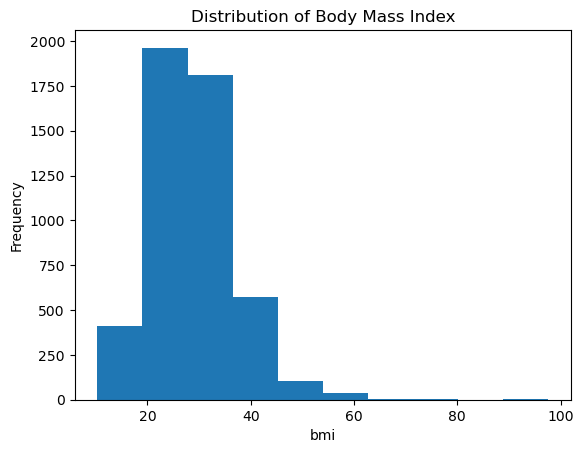

In [13]:
plt.hist(df['bmi']);
plt.xlabel('bmi');
plt.ylabel('Frequency');
plt.title('Distribution of Body Mass Index');

In [14]:
df['bmi'].fillna(df['bmi'].mean(),inplace=True)

df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# Data Visualization

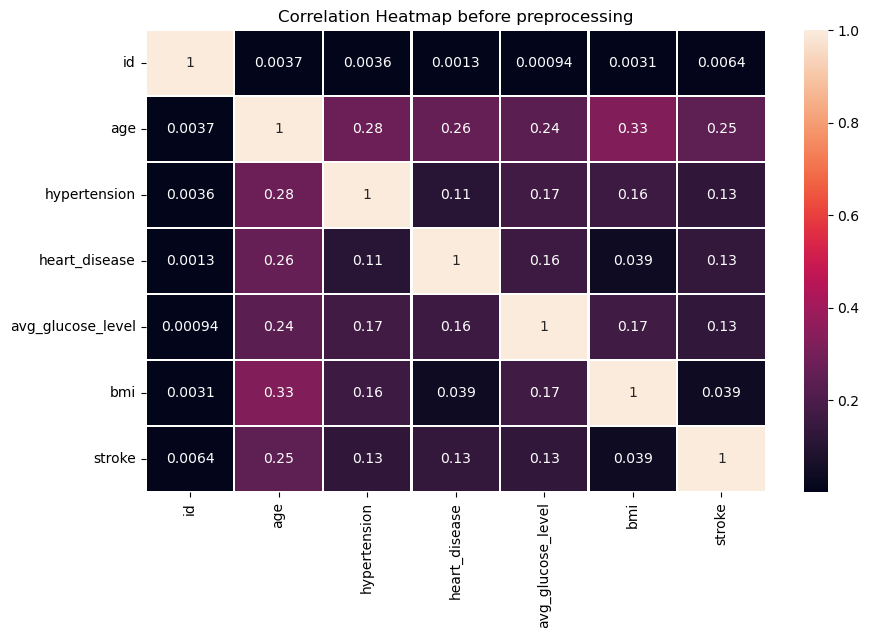

In [15]:
plt.figure(figsize=(10,6))
corr=abs(df.corr())
sns.heatmap(corr,annot=True,linewidth=1)
plt.title('Correlation Heatmap before preprocessing')
plt.show()

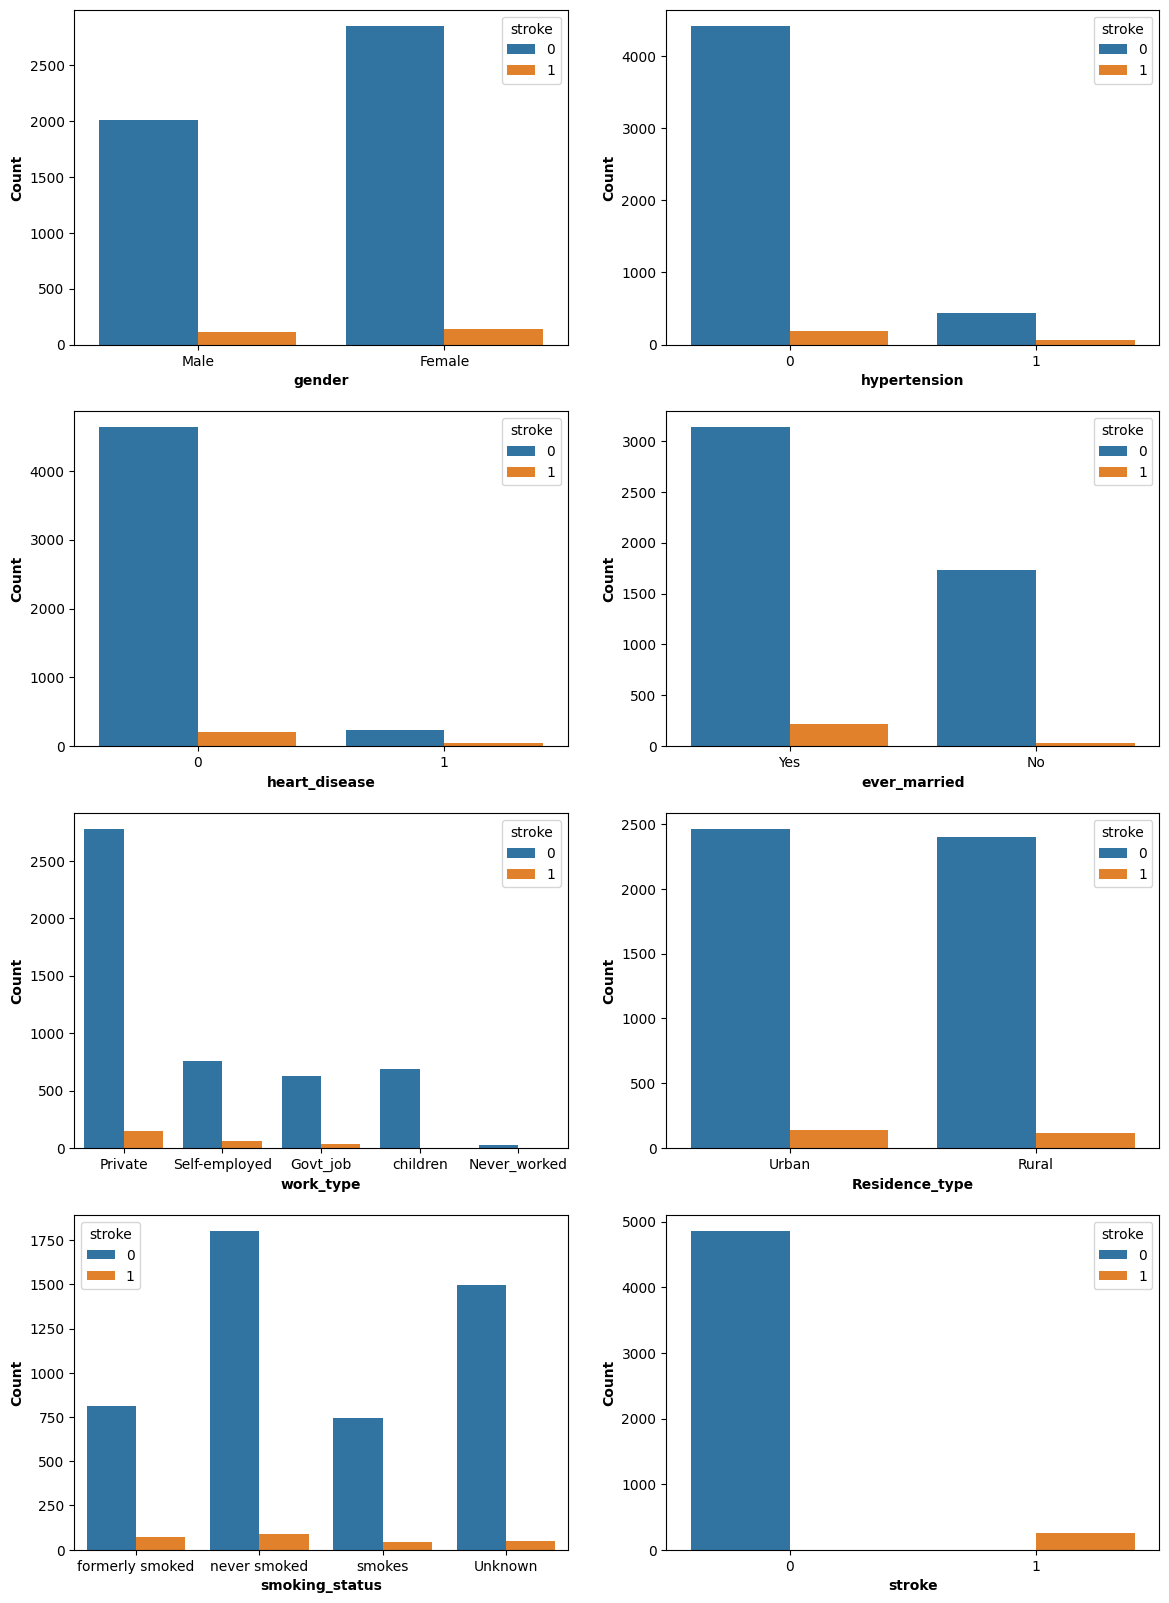

In [85]:
#Categorical Features visualization
df_cate = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status', 'stroke']

fig, axs = plt.subplots(4, 2, figsize=(14,20))
axs = axs.flatten()

for i, col_name in enumerate(df_cate):
    sns.countplot(x=col_name, data=df, ax=axs[i], hue =df['stroke'])
    axs[i].set_xlabel(f"{col_name}", weight = 'bold')
    axs[i].set_ylabel('Count', weight='bold')

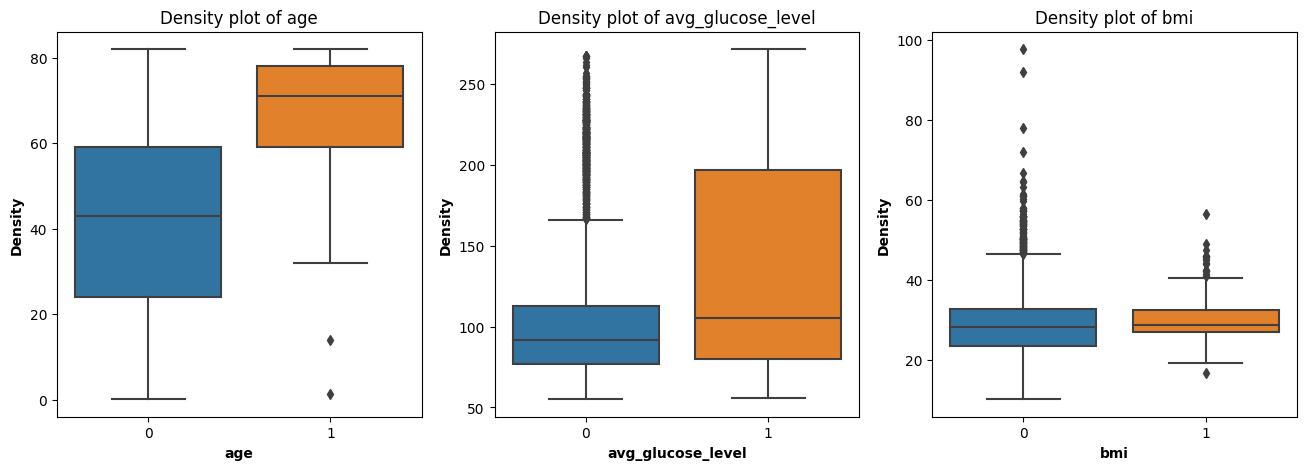

In [86]:
df_nume = ['age', 'avg_glucose_level', 'bmi']

fig, axs = plt.subplots(1, 3, figsize=(16,5))
axs = axs.flatten()

for i, col_name in enumerate(df_nume):
    sns.boxplot(x="stroke", y=col_name, data=df, ax=axs[i])
    axs[i].set_ylabel("Density", weight = 'bold')
    axs[0].set_title("Density plot of age")
    axs[1].set_title('Density plot of avg_glucose_level')
    axs[2].set_title('Density plot of bmi')
    axs[i].set_xlabel(f"{col_name}", weight='bold')
   

# Data Preprocessing

In [87]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
cat_columns=['gender','ever_married','work_type', 'Residence_type','smoking_status']
for col in cat_columns:
    df[col]=lb.fit_transform(df[col])

In [88]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.60000,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.89456,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.50000,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.40000,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.00000,2,1


In [89]:
df = df.drop('id', axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.60000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.89456,2,1
2,1,80.0,0,1,1,2,0,105.92,32.50000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.40000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.00000,2,1


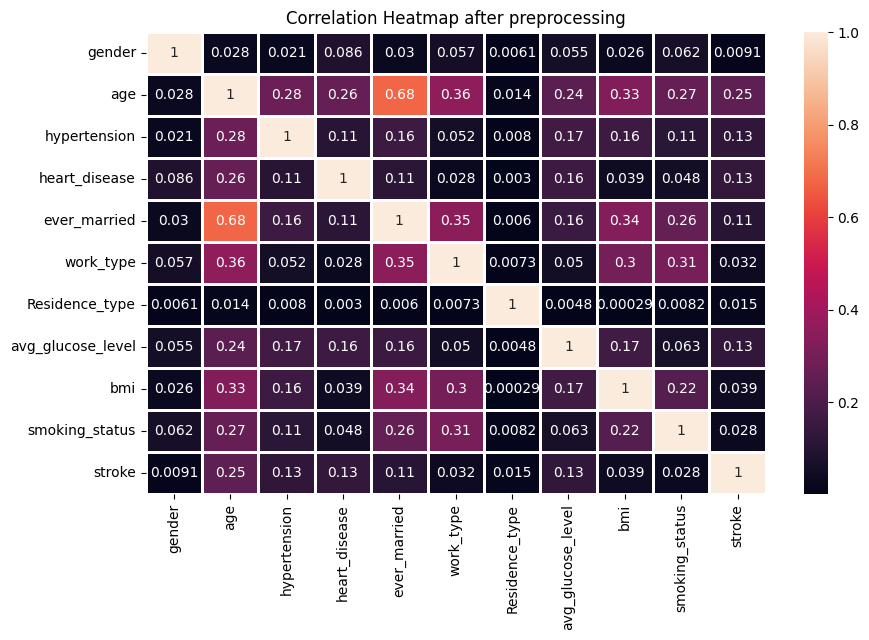

In [90]:
plt.figure(figsize=(10,6))
corr=abs(df.corr())
sns.heatmap(corr,annot=True,linewidth=1)
plt.title('Correlation Heatmap after preprocessing')
plt.show()

# Model Preparation

In [91]:
X = df.drop('stroke', axis=1)
y = df['stroke'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

Training and testing split was successful.


In [92]:
print('x_train: ', X_train.shape)
print('x_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

x_train:  (3576, 10)
x_test:  (1533, 10)
y_train:  (3576,)
y_test:  (1533,)


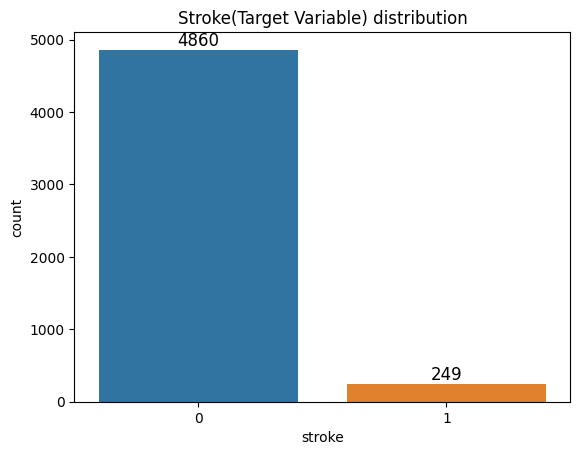

In [93]:
ax = sns.countplot(data=df, x='stroke')
for i, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), f'{p.get_height():.0f}', 
            ha='center', va='bottom', fontsize=12)
plt.title('Stroke(Target Variable) distribution')
plt.show()

In [94]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

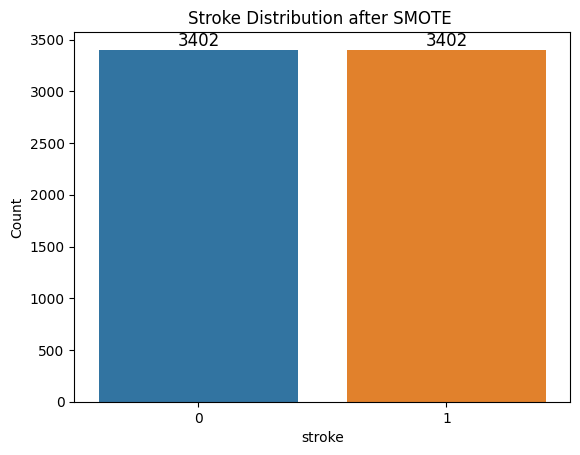

In [95]:
ax = sns.countplot(x=y_train_smote)
plt.xlabel('stroke')
plt.ylabel('Count')
plt.title('Stroke Distribution after SMOTE ')
for i, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), f'{p.get_height():.0f}', 
            ha='center', va='bottom', fontsize=12)

plt.show()

### Scaling

In [96]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [97]:
scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train_smote)
X_test_tr = scaler.transform(X_test)

# Model Training and Evaluation

### Random Forest

In [98]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [42]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tr, y_train_smote)
best_params = grid_search.best_params_
print(best_params)


{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}


#### Original Data

In [99]:
#Applying RF for original data
Rf = RandomForestClassifier(max_features='auto', random_state=42, 
                            min_samples_leaf=1, min_samples_split=2, n_estimators = 50)
Rf.fit(X_train_sc,y_train)
yhat = Rf.predict(X_test_sc)

In [100]:
# print('                Classification chart for Original Data                    \n')
print('\n Random Forest \n')
print(classification_report(y_test, yhat))


 Random Forest 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



In [101]:
print(classification_report(y_test, yhat))
#creating a list to append scores
ori_acc = []
rf_ori_acc = accuracy_score(y_test, yhat)
ori_acc.append(rf_ori_acc)
print(f'Accuracy of RF for smote Data: ',round(rf_ori_acc, 2))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533

Accuracy of RF for smote Data:  0.95


#### Smote Data

In [102]:
#Applying RF for smote data
Rf = RandomForestClassifier(max_features='auto', random_state=42, 
                            min_samples_leaf=1, min_samples_split=2, n_estimators = 50)
Rf.fit(X_train_tr,y_train_smote)
pred = Rf.predict(X_test_tr)

In [103]:
print('\n Random Forest SMOTE\n')
print(classification_report(y_test, pred))


 Random Forest SMOTE

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1458
           1       0.10      0.15      0.12        75

    accuracy                           0.89      1533
   macro avg       0.53      0.54      0.53      1533
weighted avg       0.91      0.89      0.90      1533



In [104]:
print(classification_report(y_test, pred))
#creating a list to append scores
acc = []
rf_acc = accuracy_score(y_test, pred)
acc.append(rf_acc)
print(f'Accuracy of RF for smote Data: ',round(rf_acc, 2))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1458
           1       0.10      0.15      0.12        75

    accuracy                           0.89      1533
   macro avg       0.53      0.54      0.53      1533
weighted avg       0.91      0.89      0.90      1533

Accuracy of RF for smote Data:  0.89


### KNN

#### Selecting ***Best*** n_neighbor

In [105]:
k_values = list(range(1, 11))

# Use cross-validation to evaluate the performance of each k value
cv_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_tr, y_train_smote, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the k value that gives the best performance
best_k = k_values[np.argmax(cv_scores)]
print("Best k value:", best_k)

Best k value: 2


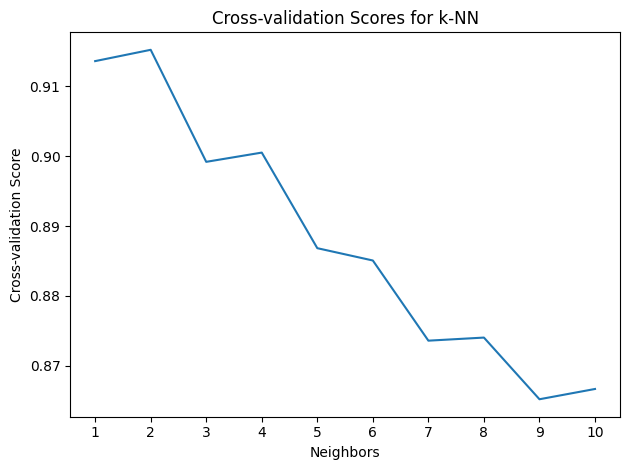




we can see "2" has the best score





In [106]:
plt.plot(k_values, cv_scores);
plt.title('Cross-validation Scores for k-NN');
plt.xticks(k_values);
plt.xlabel('Neighbors');
plt.ylabel('Cross-validation Score');
plt.tight_layout();
plt.show();
print('''


we can see "2" has the best score


''')

#### GridsearchCV

In [107]:

# Define the hyperparameter range to test
param_grid = {'n_neighbors': list(range(1, 31))}

# Create a KNN classifier object
knn = KNeighborsClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_tr, y_train_smote)

# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)


Best Hyperparameters: {'n_neighbors': 2}
Best Accuracy Score: 0.9151994640618921


#### Original Data

In [108]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_sc, y_train)
knn_yhat = knn.predict(X_test_sc)
print(classification_report(y_test, knn_yhat))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



In [109]:
print('\n KNN\n')
print(classification_report(y_test, knn_yhat))


 KNN

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



In [110]:
knn_ori_acc = accuracy_score(y_test, knn_yhat)
ori_acc.append(knn_ori_acc)

#### Smote 

In [111]:
# from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_tr, y_train_smote)
knn_pred = knn.predict(X_test_tr)
print(classification_report(y_test, knn_pred))
knn_acc = accuracy_score(y_test, knn_pred)
acc.append(knn_acc)
print(f'Accuracy of KNN for smote Data: ',round(knn_acc, 2))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1458
           1       0.08      0.16      0.11        75

    accuracy                           0.87      1533
   macro avg       0.52      0.53      0.52      1533
weighted avg       0.91      0.87      0.89      1533

Accuracy of KNN for smote Data:  0.87


In [112]:
print('KNN SMOTE\n')
print(classification_report(y_test, knn_pred))

KNN SMOTE

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1458
           1       0.08      0.16      0.11        75

    accuracy                           0.87      1533
   macro avg       0.52      0.53      0.52      1533
weighted avg       0.91      0.87      0.89      1533



### SVM

In [113]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'random_state': [42]
}
svc = SVC()
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring = 'accuracy')
grid_search.fit(X_train_tr, y_train_smote)
best_params = grid_search.best_params_
print(best_params)

{'C': 10, 'kernel': 'rbf', 'random_state': 42}


#### original

In [114]:
# SVC
svc = SVC(random_state = 42, C = 10, kernel='rbf',probability = True)
svc.fit(X_train_sc, y_train)
svm_yhat = svc.predict(X_test_sc)
print(classification_report(y_test, svm_yhat))
svc_ori_acc = accuracy_score(y_test, svm_yhat)
ori_acc.append(svc_ori_acc)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.30      0.04      0.07        75

    accuracy                           0.95      1533
   macro avg       0.63      0.52      0.52      1533
weighted avg       0.92      0.95      0.93      1533



In [115]:
print('SVM\n')
print(classification_report(y_test, svm_yhat))


SVM

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.30      0.04      0.07        75

    accuracy                           0.95      1533
   macro avg       0.63      0.52      0.52      1533
weighted avg       0.92      0.95      0.93      1533



#### smote

In [116]:
# SVC
svc = SVC(random_state = 42, C = 10, kernel='rbf',probability = True)
svc.fit(X_train_tr, y_train_smote)
svm_pred = svc.predict(X_test_tr)
print(classification_report(y_test, svm_pred))
svc_acc = accuracy_score(y_test, svm_pred)
acc.append(svc_acc)

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      1458
           1       0.10      0.35      0.15        75

    accuracy                           0.81      1533
   macro avg       0.53      0.59      0.52      1533
weighted avg       0.92      0.81      0.86      1533



In [117]:
print('SVM SMOTE\n')
print(classification_report(y_test, svm_pred))

SVM SMOTE

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      1458
           1       0.10      0.35      0.15        75

    accuracy                           0.81      1533
   macro avg       0.53      0.59      0.52      1533
weighted avg       0.92      0.81      0.86      1533



# Decision Tree

In [118]:
param_grid = {
'max_depth': np.arange(3, 15),
'criterion':['gini','entropy'],
'min_samples_leaf': [3,15,20], 
'min_samples_split': [2, 10, 100],
'random_state': [42]
}

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tr, y_train_smote)
best_params = grid_search.best_params_
print(best_params)

{'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 42}


## original

In [119]:
# DT
dt = DecisionTreeClassifier(random_state = 42, criterion = 'entropy', max_depth=14,min_samples_leaf=3,min_samples_split=2)
dt.fit(X_train_sc, y_train)
dt_yhat = dt.predict(X_test_sc)
print(classification_report(y_test, dt_yhat))
dt_ori_acc = accuracy_score(y_test, dt_yhat)
ori_acc.append(dt_ori_acc)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1458
           1       0.13      0.09      0.11        75

    accuracy                           0.92      1533
   macro avg       0.54      0.53      0.53      1533
weighted avg       0.91      0.92      0.92      1533



In [120]:
print('Decision Tree\n')
print(classification_report(y_test, dt_yhat))


Decision Tree

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1458
           1       0.13      0.09      0.11        75

    accuracy                           0.92      1533
   macro avg       0.54      0.53      0.53      1533
weighted avg       0.91      0.92      0.92      1533



## Smote

In [121]:
# DT
dt = DecisionTreeClassifier(random_state = 42, criterion = 'entropy', max_depth=14,min_samples_leaf=3,min_samples_split=2)
dt.fit(X_train_tr, y_train_smote)
dt_pred = dt.predict(X_test_tr)
print(classification_report(y_test, dt_pred))
dt_acc = accuracy_score(y_test, dt_pred)
acc.append(dt_acc)

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1458
           1       0.13      0.32      0.18        75

    accuracy                           0.86      1533
   macro avg       0.54      0.60      0.55      1533
weighted avg       0.92      0.86      0.89      1533



In [122]:
print('Decision Tree\n')
print(classification_report(y_test, dt_pred))


Decision Tree

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1458
           1       0.13      0.32      0.18        75

    accuracy                           0.86      1533
   macro avg       0.54      0.60      0.55      1533
weighted avg       0.92      0.86      0.89      1533



# Extreme Gradient Boosting

In [123]:
param_grid = {
'min_child_weight': [1, 5, 10],
'gamma': [0.5, 1, 1.5, 2, 5],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.6, 0.8, 1.0],
'max_depth': [3, 4, 5]
}

xgb = XGBClassifier()
grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tr, y_train_smote)
best_params = grid_search.best_params_
print(best_params)

{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}


## original

In [124]:
# xgb
xgb = XGBClassifier(objective='binary:logistic',max_depth=7,min_child_weight=1 ,gamma=0.5 ,subsample=1.0 ,colsample_bytree=1.0 )
xgb.fit(X_train_sc, y_train)
xgb_yhat = dt.predict(X_test_sc)
print(classification_report(y_test, xgb_yhat))
xgb_ori_acc = accuracy_score(y_test, xgb_yhat)
ori_acc.append(xgb_ori_acc)

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1458
           1       0.07      0.28      0.12        75

    accuracy                           0.79      1533
   macro avg       0.51      0.55      0.50      1533
weighted avg       0.91      0.79      0.84      1533



In [125]:
print('XGBoost classifier\n')
print(classification_report(y_test, xgb_yhat))

XGBoost classifier

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1458
           1       0.07      0.28      0.12        75

    accuracy                           0.79      1533
   macro avg       0.51      0.55      0.50      1533
weighted avg       0.91      0.79      0.84      1533



## smote

In [126]:
# xgb
xgb = XGBClassifier(objective='binary:logistic',max_depth=7,min_child_weight=1 ,gamma=0.5 ,subsample=1.0 ,colsample_bytree=1.0)
xgb.fit(X_train_tr, y_train_smote)
xgb_pred = dt.predict(X_test_tr)
print(classification_report(y_test, xgb_pred))
xgb_acc = accuracy_score(y_test, xgb_pred)
acc.append(xgb_acc)

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1458
           1       0.13      0.32      0.18        75

    accuracy                           0.86      1533
   macro avg       0.54      0.60      0.55      1533
weighted avg       0.92      0.86      0.89      1533



In [127]:
print('XGBoost classifier\n')
print(classification_report(y_test, xgb_pred))


XGBoost classifier

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1458
           1       0.13      0.32      0.18        75

    accuracy                           0.86      1533
   macro avg       0.54      0.60      0.55      1533
weighted avg       0.92      0.86      0.89      1533



# Model Comparison

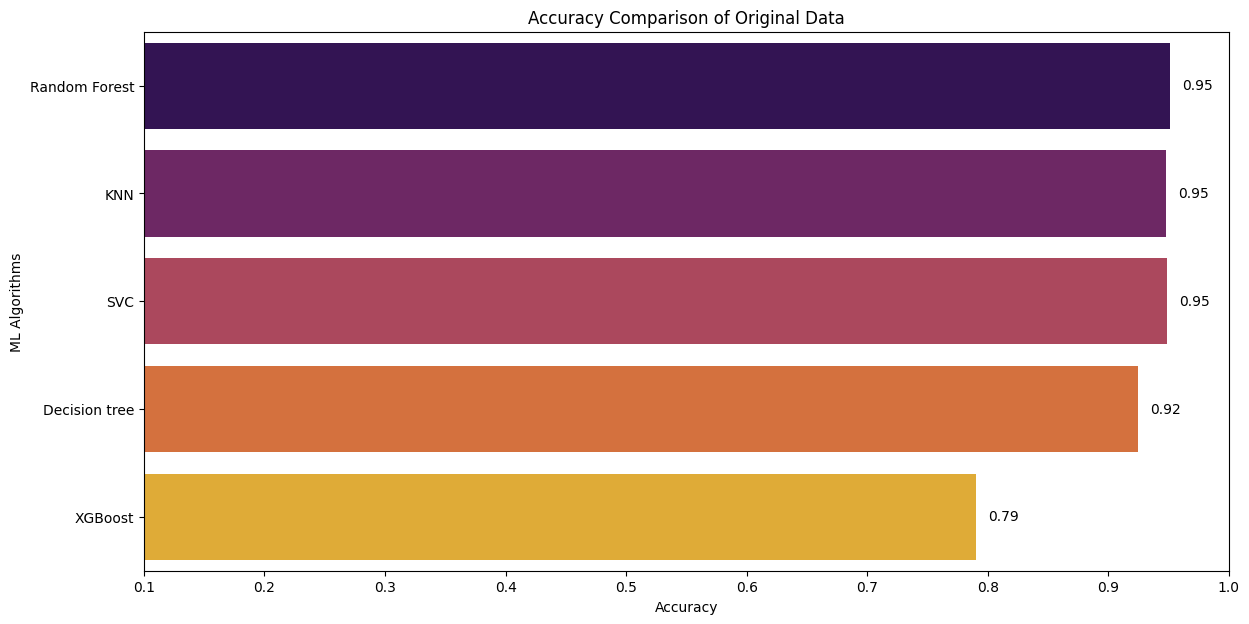

In [130]:
model = ['Random Forest', 'KNN', 'SVC','Decision tree','XGBoost']
plt.figure(figsize=[14,7],dpi = 100, facecolor='white');
plt.title('Accuracy Comparison of Original Data');
plt.xlabel('Accuracy');
plt.ylabel('ML Algorithms');
ax=sns.barplot(x = ori_acc,y = model,palette='inferno');
ax.set_xlim(0.1, 1.0)
for i, v in enumerate(ori_acc):
    ax.text(v+0.01, i, str(round(v, 2)), va='center')
plt.show()

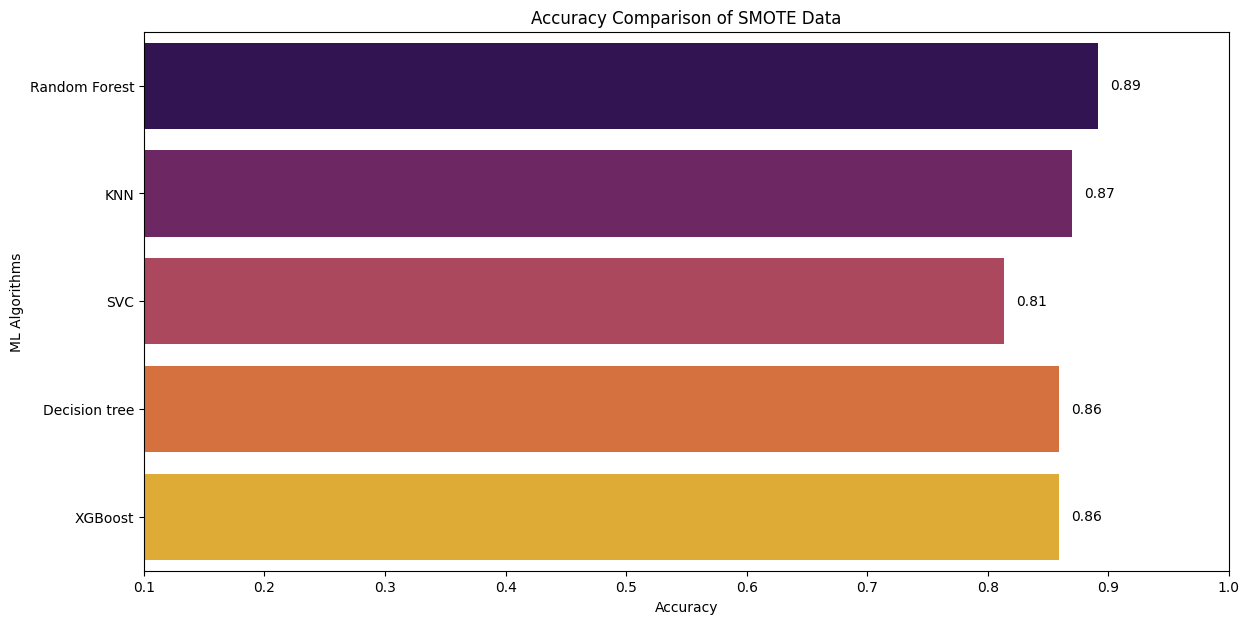

In [133]:
model = ['Random Forest', 'KNN', 'SVC','Decision tree','XGBoost']
plt.figure(figsize=[14,7],dpi = 100, facecolor='white');
plt.title('Accuracy Comparison of SMOTE Data');
plt.xlabel('Accuracy');
plt.ylabel('ML Algorithms');
ax=sns.barplot(x = acc,y = model,palette='inferno');
ax.set_xlim(0.1, 1.0)
for i, v in enumerate(acc):
    ax.text(v+0.01, i, str(round(v, 2)), va='center')
plt.show()

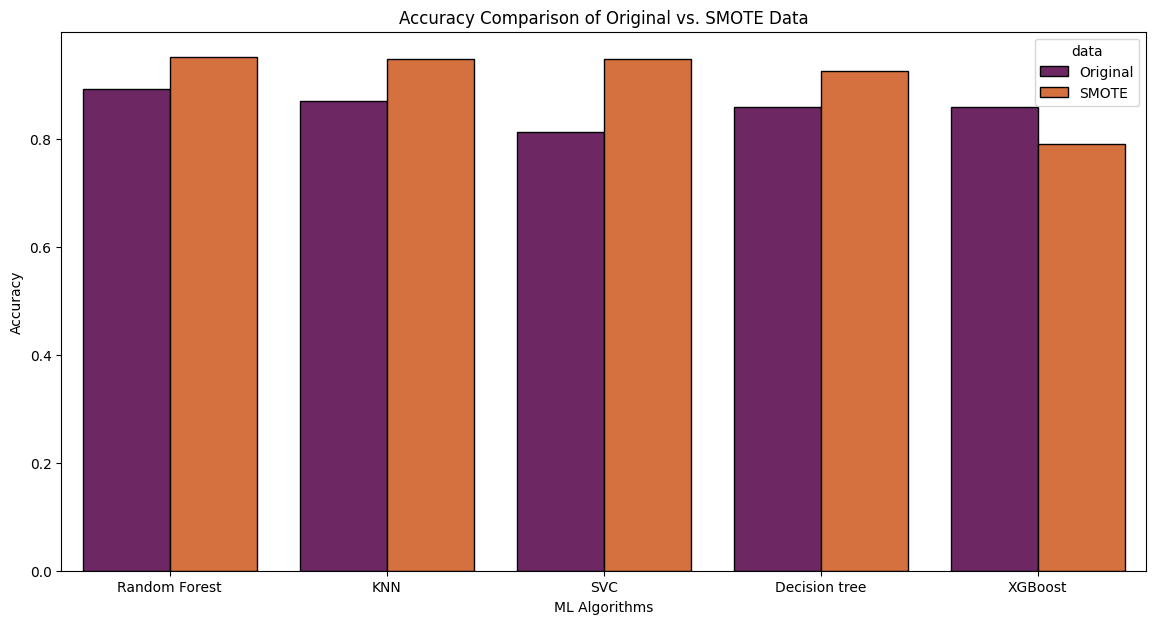

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a data frame for the results
df = pd.DataFrame({'model': model * 2, 'accuracy': acc + ori_acc, 'data': ['Original'] * len(model) + ['SMOTE'] * len(model)})

# plot the results
plt.figure(figsize=[14,7],dpi = 100, facecolor='white');
sns.barplot(x='model', y='accuracy', hue='data', data=df, palette='inferno', edgecolor='black')
# add values on top of bars
for p in ax.containers:
    ax.bar_label(p, label_type='center', fontsize=10)
plt.title('Accuracy Comparison of Original vs. SMOTE Data');
plt.xlabel('ML Algorithms');
plt.ylabel('Accuracy');
plt.show()
